<a href="https://colab.research.google.com/github/hmlewis-astro/street_network_deep_learning/blob/main/test_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Change to GPU runtime

#### Navigate to "Runtime > Change runtime type > GPU > Save"

# Download Kaggle API credentials
#### **Note**: This is a one-time step and you don’t need to generate the credentials every time you download the dataset.
- Navigate to your Kaggle profile
- Click the "Account" tab
- Scroll down to the "API" section
- Click "Create New API Token"; a file named `kaggle.json` will be download which contains your username and API key

# Upload Kaggle API credentials to Google Colab
#### **Note**: Uploaded files will get deleted when this runtime is recycled.
- Upload the `kaggle.json` file that you just downloaded from Kaggle
- Run the following cell

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download balraj98/deepglobe-road-extraction-dataset

100% 3.79G/3.79G [01:06<00:00, 50.3MB/s]
100% 3.79G/3.79G [01:06<00:00, 61.0MB/s]


In [2]:
!unzip -q /content/deepglobe-road-extraction-dataset.zip -d /content/deep-globe

# Import packages and libraries

In [3]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf

from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

# Get class dictionary

In [4]:
class_dict_path = "/content/deep-globe/class_dict.csv"
class_dict = pd.read_csv(class_dict_path)
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()
class_dict

,name,r,g,b
0,road,255,255,255
1,background,0,0,0


# Get metadata

In [5]:
metadata_path = "/content/deep-globe/metadata.csv"
metadata = pd.read_csv(metadata_path)
metadata.head()

,image_id,split,sat_image_path,mask_path
0,100034,train,train/100034_sat.jpg,train/100034_mask.png
1,100081,train,train/100081_sat.jpg,train/100081_mask.png
2,100129,train,train/100129_sat.jpg,train/100129_mask.png
3,100703,train,train/100703_sat.jpg,train/100703_mask.png
4,100712,train,train/100712_sat.jpg,train/100712_mask.png


### Get training/validation data (i.e., images with available road masks)


In [ ]:
metadata_train = metadata[metadata['split'] == 'train']
metadata_train.drop('split', inplace=True, axis=1)
metadata_train.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,image_id,sat_image_path,mask_path
0,100034,train/100034_sat.jpg,train/100034_mask.png
1,100081,train/100081_sat.jpg,train/100081_mask.png
2,100129,train/100129_sat.jpg,train/100129_mask.png
3,100703,train/100703_sat.jpg,train/100703_mask.png
4,100712,train/100712_sat.jpg,train/100712_mask.png


In [ ]:
metadata_train = metadata_train.sample(frac=1).reset_index(drop=True)

In [ ]:
metadata_train.shape

(6226, 3)

### Get test data (i.e., images without available road masks)

Combine the datasets defined (by Kaggle) as "validation" and "test", because the "validation" set does not have road masks, so cannot actually be used for validation

In [ ]:
metadata_test = metadata[(metadata['split'] == 'valid') | 
                         (metadata['split'] == 'test')]
metadata_test.drop(['split', 'mask_path'], inplace=True, axis=1)
metadata_test.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,image_id,sat_image_path
6226,100794,valid/100794_sat.jpg
6227,100905,valid/100905_sat.jpg
6228,102867,valid/102867_sat.jpg
6229,10417,valid/10417_sat.jpg
6230,106553,valid/106553_sat.jpg


In [ ]:
metadata_test = metadata_test.sample(frac=1).reset_index(drop=True)

In [ ]:
metadata_test.shape

(2344, 2)

In [ ]:
data_path = "/content/deep-globe/"


In [ ]:
metadata_train["sat_image_path"] = metadata_train["sat_image_path"] \
                                    .apply(lambda x: os.path.join(data_path, x))
metadata_train["mask_path"] = metadata_train["mask_path"] \
                                    .apply(lambda x: os.path.join(data_path, x))


In [ ]:
metadata_test["sat_image_path"] = metadata_test["sat_image_path"] \
                                    .apply(lambda x: os.path.join(data_path, x))


In [ ]:
metadata_train.head()

,image_id,sat_image_path,mask_path
0,961531,/content/deep-globe/train/961531_sat.jpg,/content/deep-globe/train/961531_mask.png
1,723722,/content/deep-globe/train/723722_sat.jpg,/content/deep-globe/train/723722_mask.png
2,782351,/content/deep-globe/train/782351_sat.jpg,/content/deep-globe/train/782351_mask.png
3,377745,/content/deep-globe/train/377745_sat.jpg,/content/deep-globe/train/377745_mask.png
4,547924,/content/deep-globe/train/547924_sat.jpg,/content/deep-globe/train/547924_mask.png


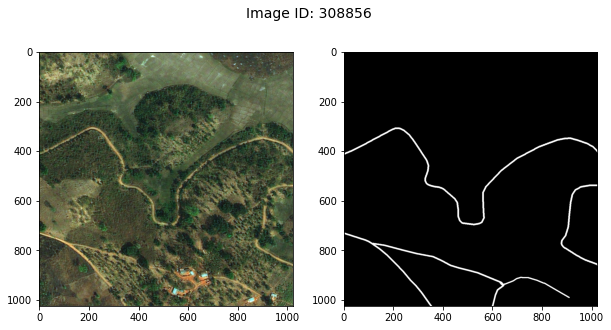

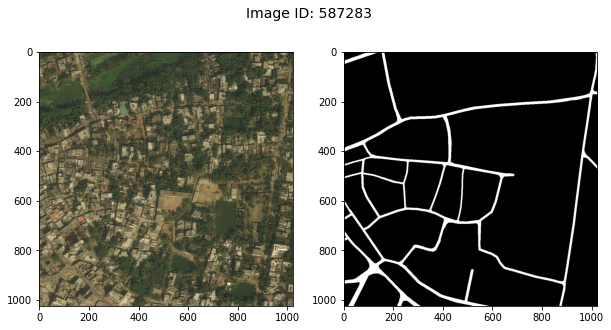

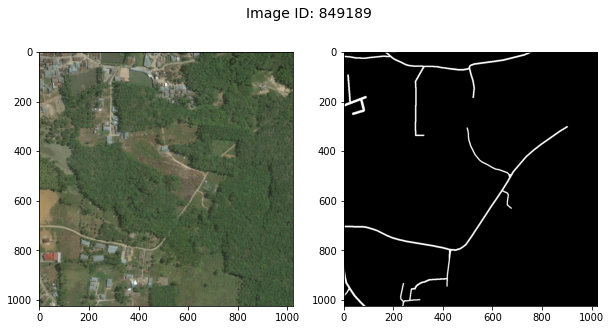

In [ ]:
img_idx = np.random.choice(range(len(metadata_train)), size=3)

for i in img_idx:
  sat_img = cv2.cvtColor(cv2.imread(metadata_train['sat_image_path'][i]), 
                         cv2.COLOR_BGR2RGB)
  sat_mask = cv2.cvtColor(cv2.imread(metadata_train['mask_path'][i]), 
                          cv2.COLOR_BGR2RGB)

  fig, ax = plt.subplots(1, 2, figsize=(10,5))

  fig.suptitle('Image ID: {}'.format(metadata_train['image_id'][i]), 
               fontsize=14)
  ax[0].imshow(sat_img)
  ax[1].imshow(sat_mask);


In [ ]:
sat_img.shape, sat_mask.shape

((1024, 1024, 3), (1024, 1024, 3))

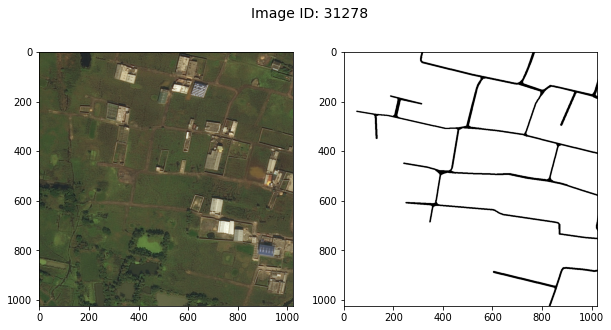

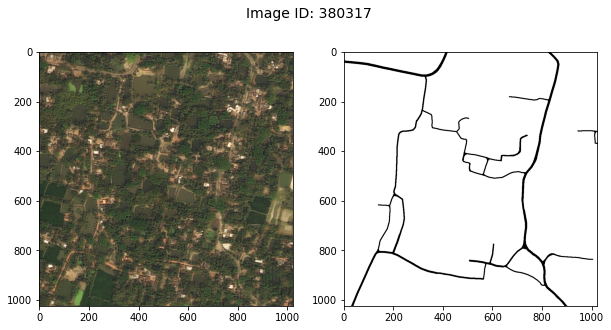

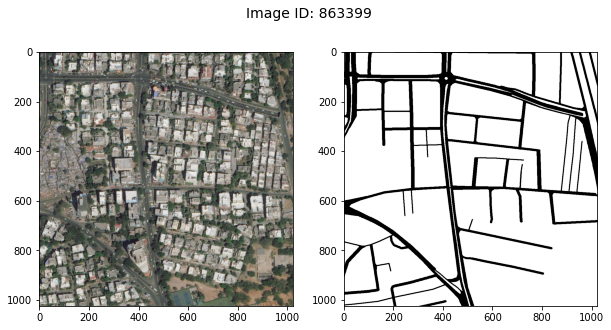

In [ ]:
img_idx = np.random.choice(range(len(metadata_train)), size=3)

for i in img_idx:
  sat_img = cv2.cvtColor(cv2.imread(metadata_train['sat_image_path'][i]), 
                         cv2.COLOR_BGR2RGB)
  sat_mask = cv2.cvtColor(cv2.imread(metadata_train['mask_path'][i]), 
                          cv2.COLOR_BGR2RGB)[:,:,0]

  fig, ax = plt.subplots(1, 2, figsize=(10,5))

  fig.suptitle('Image ID: {}'.format(metadata_train['image_id'][i]), 
               fontsize=14)
  ax[0].imshow(sat_img)
  ax[1].imshow(sat_mask, cmap='Greys');

In [ ]:
sat_img.shape, sat_mask.shape

((1024, 1024, 3), (1024, 1024))

In [ ]:
img_dim, img_dim = sat_mask.shape


In [ ]:
sat_img_array = []
sat_mask_array = []
for i,img in metadata_train.iterrows():
  sat_img_array.append(cv2.cvtColor(cv2.imread(img['sat_image_path']), 
                              cv2.COLOR_BGR2RGB))
  sat_mask_array.append(cv2.cvtColor(cv2.imread(img['mask_path']), 
                               cv2.COLOR_BGR2RGB)[:,:,0])
  
  # run baseline model (PCA) on a subset of the data
  if i == 99:
    break

sat_img_array = np.stack(sat_img_array, axis=-1).reshape((-1,img_dim,img_dim,3))
sat_mask_array = np.stack(sat_mask_array, axis=-1).reshape((-1,img_dim,img_dim,1))

In [ ]:
sat_img_array.shape

In [ ]:
X_img = sat_img_array
Y_img = sat_mask_array

X_train, X_test, y_train, y_test = (train_test_split(X_img, Y_img, 
                                                     test_size = 0.2, random_state = 42))

y_train_cat = tf.keras.utils.to_categorical(y_train)


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def ohe(label, classes):
    """
    Convert a segmentation mask to one-hot format by replacing each pixel value 
    with a vector of length equal to the number of classes
    # arguments
        label: 2D array segmentation mask
        classes: dictionary of class values
        
    # returns
        2D array with the same width and hieght as the input, but with a depth
        equal to the number of classes
    """
    semantic_map = []
    for colour in classes:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

In [ ]:
def reverse_ohe(image):
    """
    Transform a 2D array in ohe format (depth equal to the number of
    classes), to a 2D array with depth 1, where each pixel value is the class 
    # arguments
        image: ohe format image 
        
    # returns
        2D array with the same width and hieght as the input, but
        with depth 1
    """
    x = np.argmax(image, axis = -1)
    return x